In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load data
df = pd.read_csv('../data/rejection_analysis_extended.csv')

# Exclude ghosted emails
df = df[df['status'] != 'ghosted']

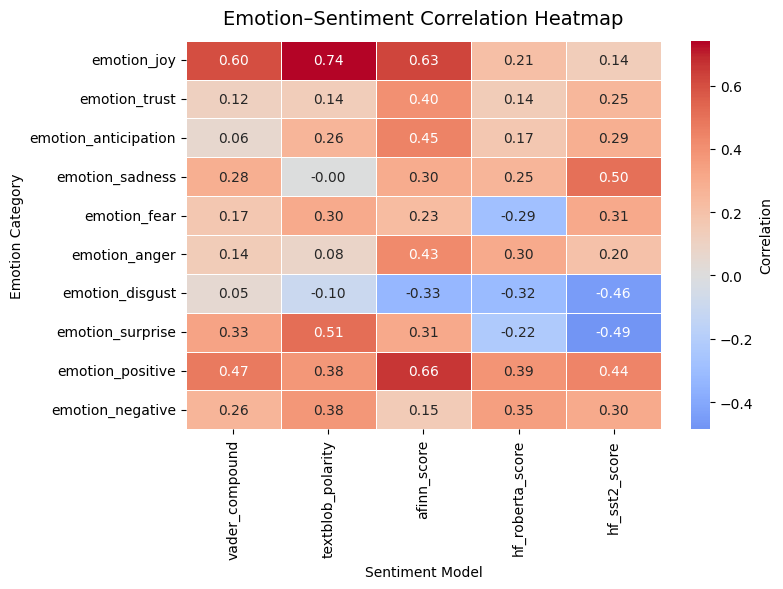

In [7]:
# Emotion and sentiment columns
emotion_cols = [col for col in df.columns if col.startswith('emotion_')]
sentiment_cols = ['vader_compound', 'textblob_polarity', 'afinn_score',
                  'hf_roberta_score', 'hf_sst2_score']

# Correlation matrix
corr = df[emotion_cols + sentiment_cols].corr()[sentiment_cols].loc[emotion_cols]

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(
    corr, 
    annot=True, fmt=".2f", cmap="coolwarm", center=0,
    linewidths=0.5, cbar_kws={'label': 'Correlation'}
)
plt.title("Emotion–Sentiment Correlation Heatmap", fontsize=14, pad=12)
plt.xlabel("Sentiment Model")
plt.ylabel("Emotion Category")
plt.tight_layout()

# Save and show
plt.savefig('../visualizations/emotion_sentiment_heatmap.png', dpi=300)
plt.show()



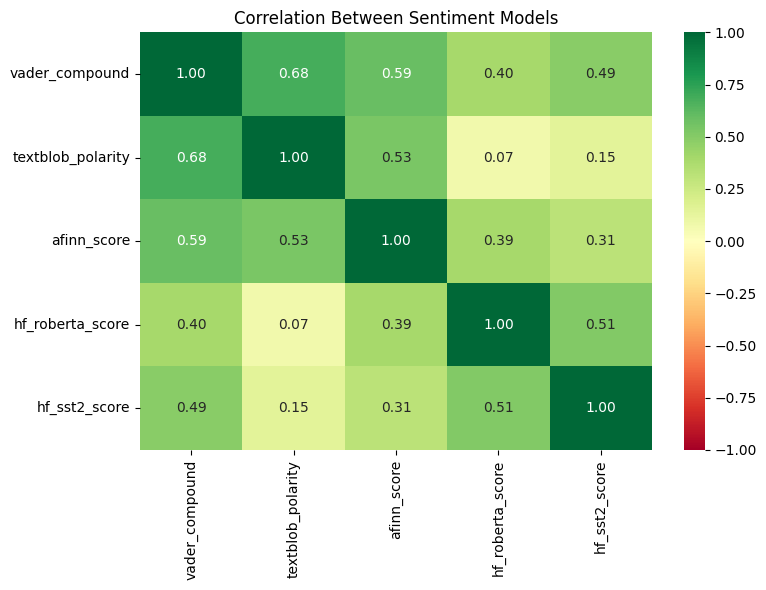

In [8]:

cols = ['vader_compound', 'textblob_polarity', 'afinn_score', 'hf_roberta_score', 'hf_sst2_score']
df_models = df[cols]

# Compute correlation matrix
corr = df_models.corr()

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="RdYlGn", vmin=-1, vmax=1)
plt.title("Correlation Between Sentiment Models")
plt.tight_layout()
plt.show()


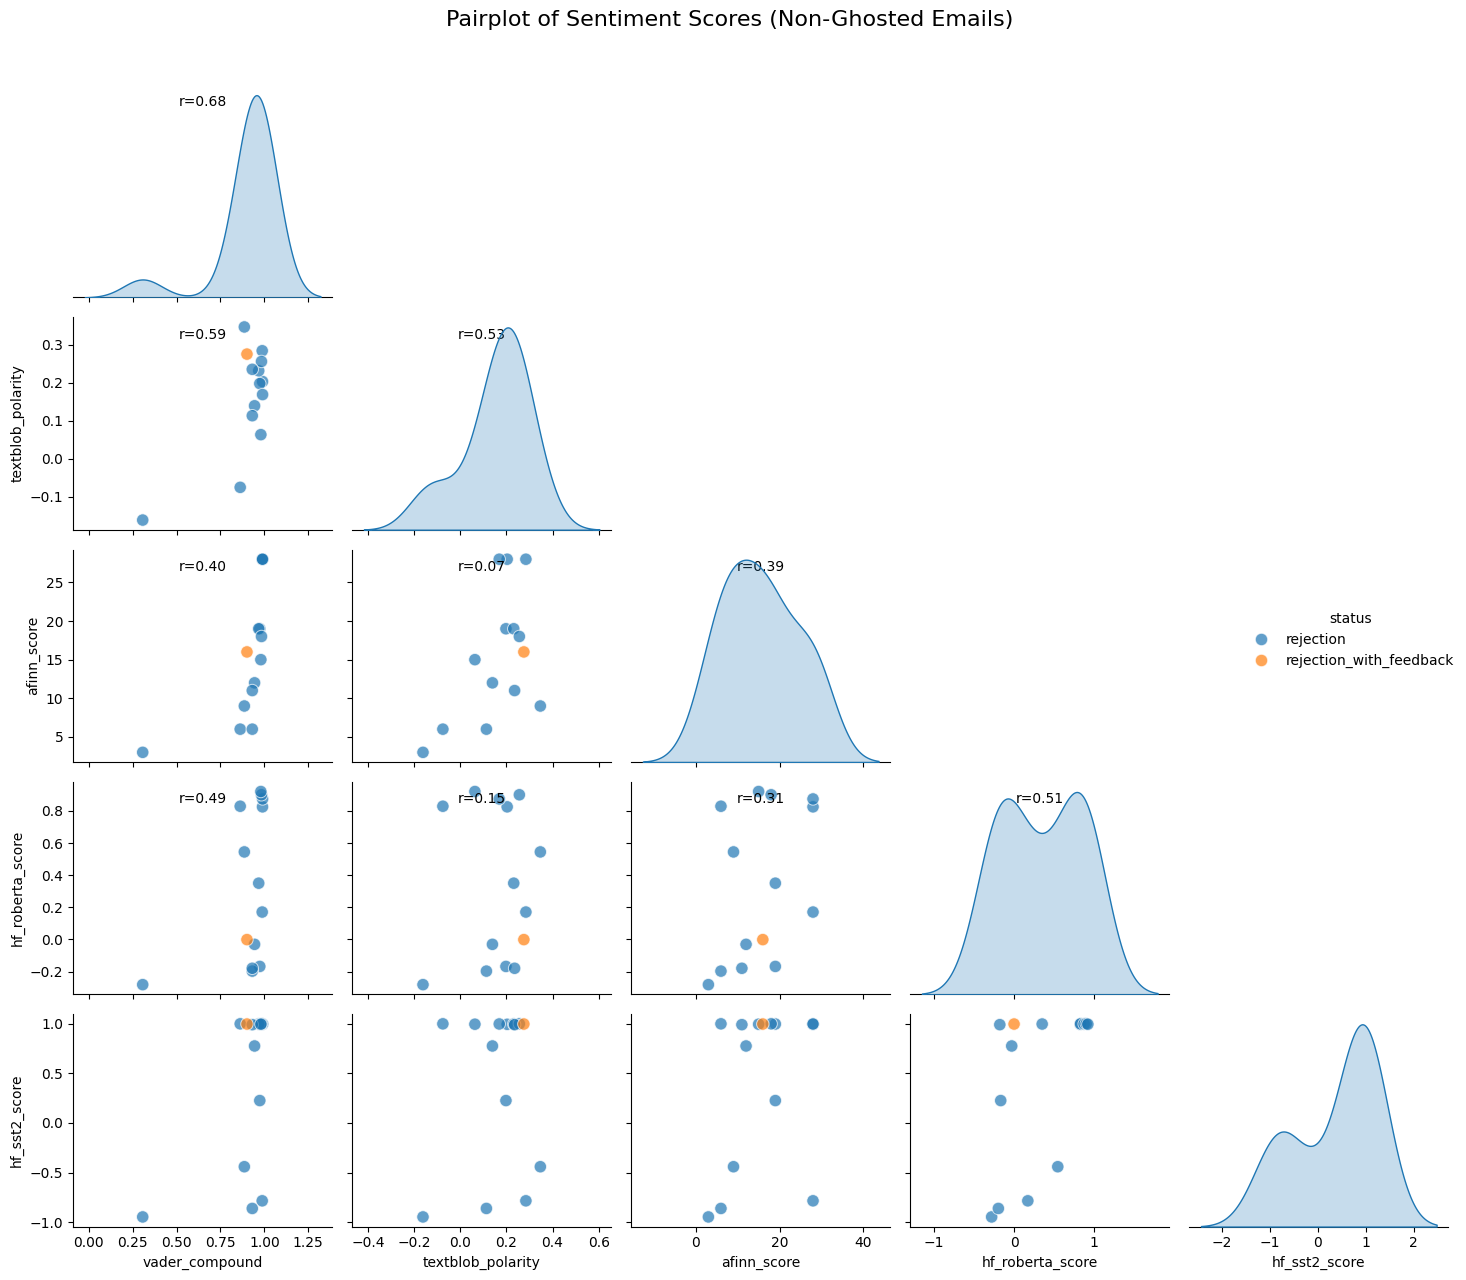

In [9]:
df = df[df['status'] != 'ghosted']

# Sentiment columns
sentiment_cols = ['vader_compound', 'textblob_polarity', 'afinn_score',
                  'hf_roberta_score', 'hf_sst2_score']

# Subset the data
df_sentiment = df[sentiment_cols + ['status']]

# Pairplot with hue
pairplot = sns.pairplot(df_sentiment, hue='status', corner=True,
                        plot_kws={'alpha':0.7, 's':80})

# Annotate correlation on the upper triangle (adjusted for corner)
num_vars = len(sentiment_cols)
for i in range(num_vars):
    for j in range(i+1, num_vars):
        ax = pairplot.axes[j-1, i]  # row=j-1, col=i in corner=True
        if ax is not None:
            corr_val = np.corrcoef(df_sentiment[sentiment_cols[i]],
                                    df_sentiment[sentiment_cols[j]])[0,1]
            ax.annotate(f"r={corr_val:.2f}", xy=(0.5,0.9), xycoords='axes fraction',
                        ha='center', fontsize=10, color='black')

# Adjust and save
plt.suptitle("Pairplot of Sentiment Scores (Non-Ghosted Emails)", fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('../visualizations/sentiment_pairplot.png', dpi=300)
plt.show()




In [10]:
df_transformer = df[df['status'] != 'ghosted']


print("RoBERTa scores:")
print(df_transformer['hf_roberta_score'].describe())

print("\nSST-2 scores:")
print(df_transformer['hf_sst2_score'].describe())


RoBERTa scores:
count    14.000000
mean      0.325346
std       0.475344
min      -0.281681
25%      -0.133988
50%       0.260065
75%       0.828082
max       0.920622
Name: hf_roberta_score, dtype: float64

SST-2 scores:
count    14.000000
mean      0.424212
std       0.809598
min      -0.946643
25%      -0.274056
50%       0.992432
75%       0.997042
max       0.999254
Name: hf_sst2_score, dtype: float64


In [11]:
transformer_cols = ['hf_roberta_score', 'hf_sst2_score']
lexicon_cols = ['vader_compound', 'textblob_polarity', 'afinn_score']

for t_col in transformer_cols:
    for l_col in lexicon_cols:
        corr_val = df_transformer[t_col].corr(df_transformer[l_col])
        print(f"{t_col} vs {l_col}: r = {corr_val:.2f}")


hf_roberta_score vs vader_compound: r = 0.40
hf_roberta_score vs textblob_polarity: r = 0.07
hf_roberta_score vs afinn_score: r = 0.39
hf_sst2_score vs vader_compound: r = 0.49
hf_sst2_score vs textblob_polarity: r = 0.15
hf_sst2_score vs afinn_score: r = 0.31


In [12]:
df = df[df['status'] != 'ghosted'].copy()

# Normalize AFINN score to roughly [-1, 1] for comparison
afinn_max_abs = df['afinn_score'].abs().max()
df['afinn_score_norm'] = df['afinn_score'] / afinn_max_abs if afinn_max_abs != 0 else df['afinn_score']

# Compute average lexicon score
df['lexicon_avg'] = df[['vader_compound', 'textblob_polarity', 'afinn_score_norm']].mean(axis=1)

# Compute max disagreement vs transformers
df['max_disagreement_roberta'] = (df['lexicon_avg'] - df['hf_roberta_score']).abs()
df['max_disagreement_sst2'] = (df['lexicon_avg'] - df['hf_sst2_score']).abs()
df['max_disagreement'] = df[['max_disagreement_roberta', 'max_disagreement_sst2']].max(axis=1)

def disagreement_note(row):
    if row['max_disagreement'] == row['max_disagreement_roberta']:
        return 'RoBERTa disagrees most'
    else:
        return 'SST-2 disagrees most'

df['note'] = df.apply(disagreement_note, axis=1)

# Select relevant columns for comparison table
cols = ['company_id', 'email_text', 'vader_compound', 'textblob_polarity', 
        'afinn_score', 'hf_roberta_score', 'hf_sst2_score', 'max_disagreement', 'note']
comparison_table = df[cols].sort_values(by='max_disagreement', ascending=False)

# Save to CSV
comparison_table.to_csv('../data/sentiment_disagreement_highlights.csv', index=False)

# Display top 5 largest disagreements
print("Top 5 emails with biggest disagreement between lexicon vs Transformer models:")
print(comparison_table.head(5))


Top 5 emails with biggest disagreement between lexicon vs Transformer models:
   company_id                                         email_text  \
1   Company_B  Hello, Thank you for your interest in joining ...   
9   Company_J  Hi [Name], First of all my apologies for not g...   
3   Company_D  Hi [Name], Thanks for taking the time to apply...   
10  Company_K  Hi [Name], Thank you for your interest in our ...   
2   Company_C  Hi [Name], Thanks for your application with [C...   

    vader_compound  textblob_polarity  afinn_score  hf_roberta_score  \
1           0.9878           0.284615         28.0          0.170246   
9           0.9313           0.113636          6.0         -0.197509   
3           0.3071          -0.161111          3.0         -0.281681   
10          0.8860           0.347273          9.0          0.544591   
2           0.9739           0.198214         19.0         -0.168369   

    hf_sst2_score  max_disagreement                    note  
1       -0.784227 

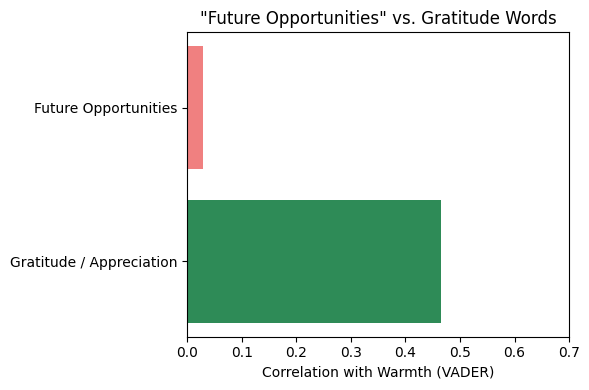

In [17]:

keywords = ['future_keywords', 'empathy_words'] 
correlations = [
    df['mentions_future'].corr(df['vader_compound']),
    df['empathy_words'].corr(df['vader_compound'])
]

words = ['Future Opportunities', 'Gratitude / Appreciation']
colors = ['lightcoral' if x < 0.2 else 'seagreen' for x in correlations]

plt.figure(figsize=(6,4))
plt.barh(words, correlations, color=colors)
plt.xlabel("Correlation with Warmth (VADER)")
plt.xlim(0, 0.7)
plt.gca().invert_yaxis()
plt.title('"Future Opportunities" vs. Gratitude Words')
plt.tight_layout()
plt.savefig('../visualizations/future_vs_gratitude.png', dpi=300)
plt.show()



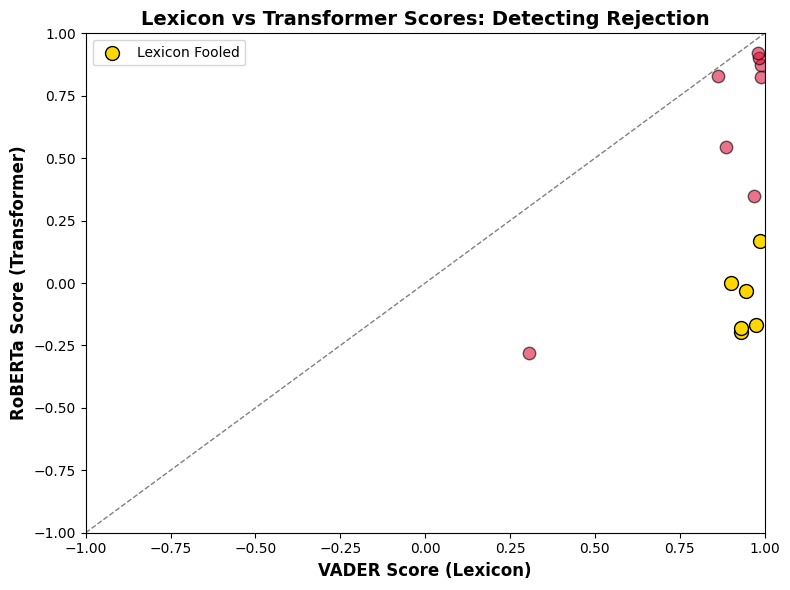

In [15]:

# Filter out ghosted applications if desired
df_plot = df[df['status'] != 'ghosted']

# Scatter plot: Lexicon (VADER) vs Transformer (RoBERTa)
plt.figure(figsize=(8, 6))
plt.scatter(df_plot['vader_compound'], df_plot['hf_roberta_score'],
            c='crimson', alpha=0.6, edgecolors='k', s=80)

# Diagonal line for reference (y=x)
lims = [-1, 1]
plt.plot(lims, lims, '--', color='gray', linewidth=1)

plt.xlabel("VADER Score (Lexicon)", fontsize=12, fontweight='bold')
plt.ylabel("RoBERTa Score (Transformer)", fontsize=12, fontweight='bold')
plt.title("Lexicon vs Transformer Scores: Detecting Rejection", fontsize=14, fontweight='bold')
plt.xlim(lims)
plt.ylim(lims)


threshold_lexicon = 0.5 
threshold_transformer = 0.2  
fooled = df_plot[(df_plot['vader_compound'] > threshold_lexicon) &
                 (df_plot['hf_roberta_score'] < threshold_transformer)]

plt.scatter(fooled['vader_compound'], fooled['hf_roberta_score'],
            c='gold', edgecolors='k', s=100, label='Lexicon Fooled')

plt.legend()
plt.tight_layout()
plt.savefig("../visualizations/lexicon_vs_transformer.png", dpi=300)
plt.show()


In [18]:
# Filter the email
email_row = df[df['company_id'] == 'Company_B'].iloc[0]
text = email_row['email_text']

# VADER score
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
vader = SentimentIntensityAnalyzer()
vader_scores = vader.polarity_scores(text)
print("VADER scores:", vader_scores)

# Count positive/negative words (approximate)
words = text.lower().split()
positive_words = [w for w in words if vader.lexicon.get(w, 0) > 0]
negative_words = [w for w in words if vader.lexicon.get(w, 0) < 0]
print(f"Positive words: {len(positive_words)} → {positive_words}")
print(f"Negative words: {len(negative_words)} → {negative_words}")

# RoBERTa score
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
with torch.no_grad():
    logits = model(**inputs).logits
    probs = torch.softmax(logits, dim=1).numpy()[0]

roberta_score = probs[2] - probs[0]  # positive - negative
print("RoBERTa score:", roberta_score)


VADER scores: {'neg': 0.056, 'neu': 0.681, 'pos': 0.263, 'compound': 0.9878}
Positive words: 14 → ['thank', 'interest', 'best', 'great', 'help', 'like', 'beautifully', 'highlight', 'matters', 'easily', 'better', 'good', 'luck', 'dream']
Negative words: 2 → ['mistakes', 'no']


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


RoBERTa score: 0.17024624


✅ Data loaded!


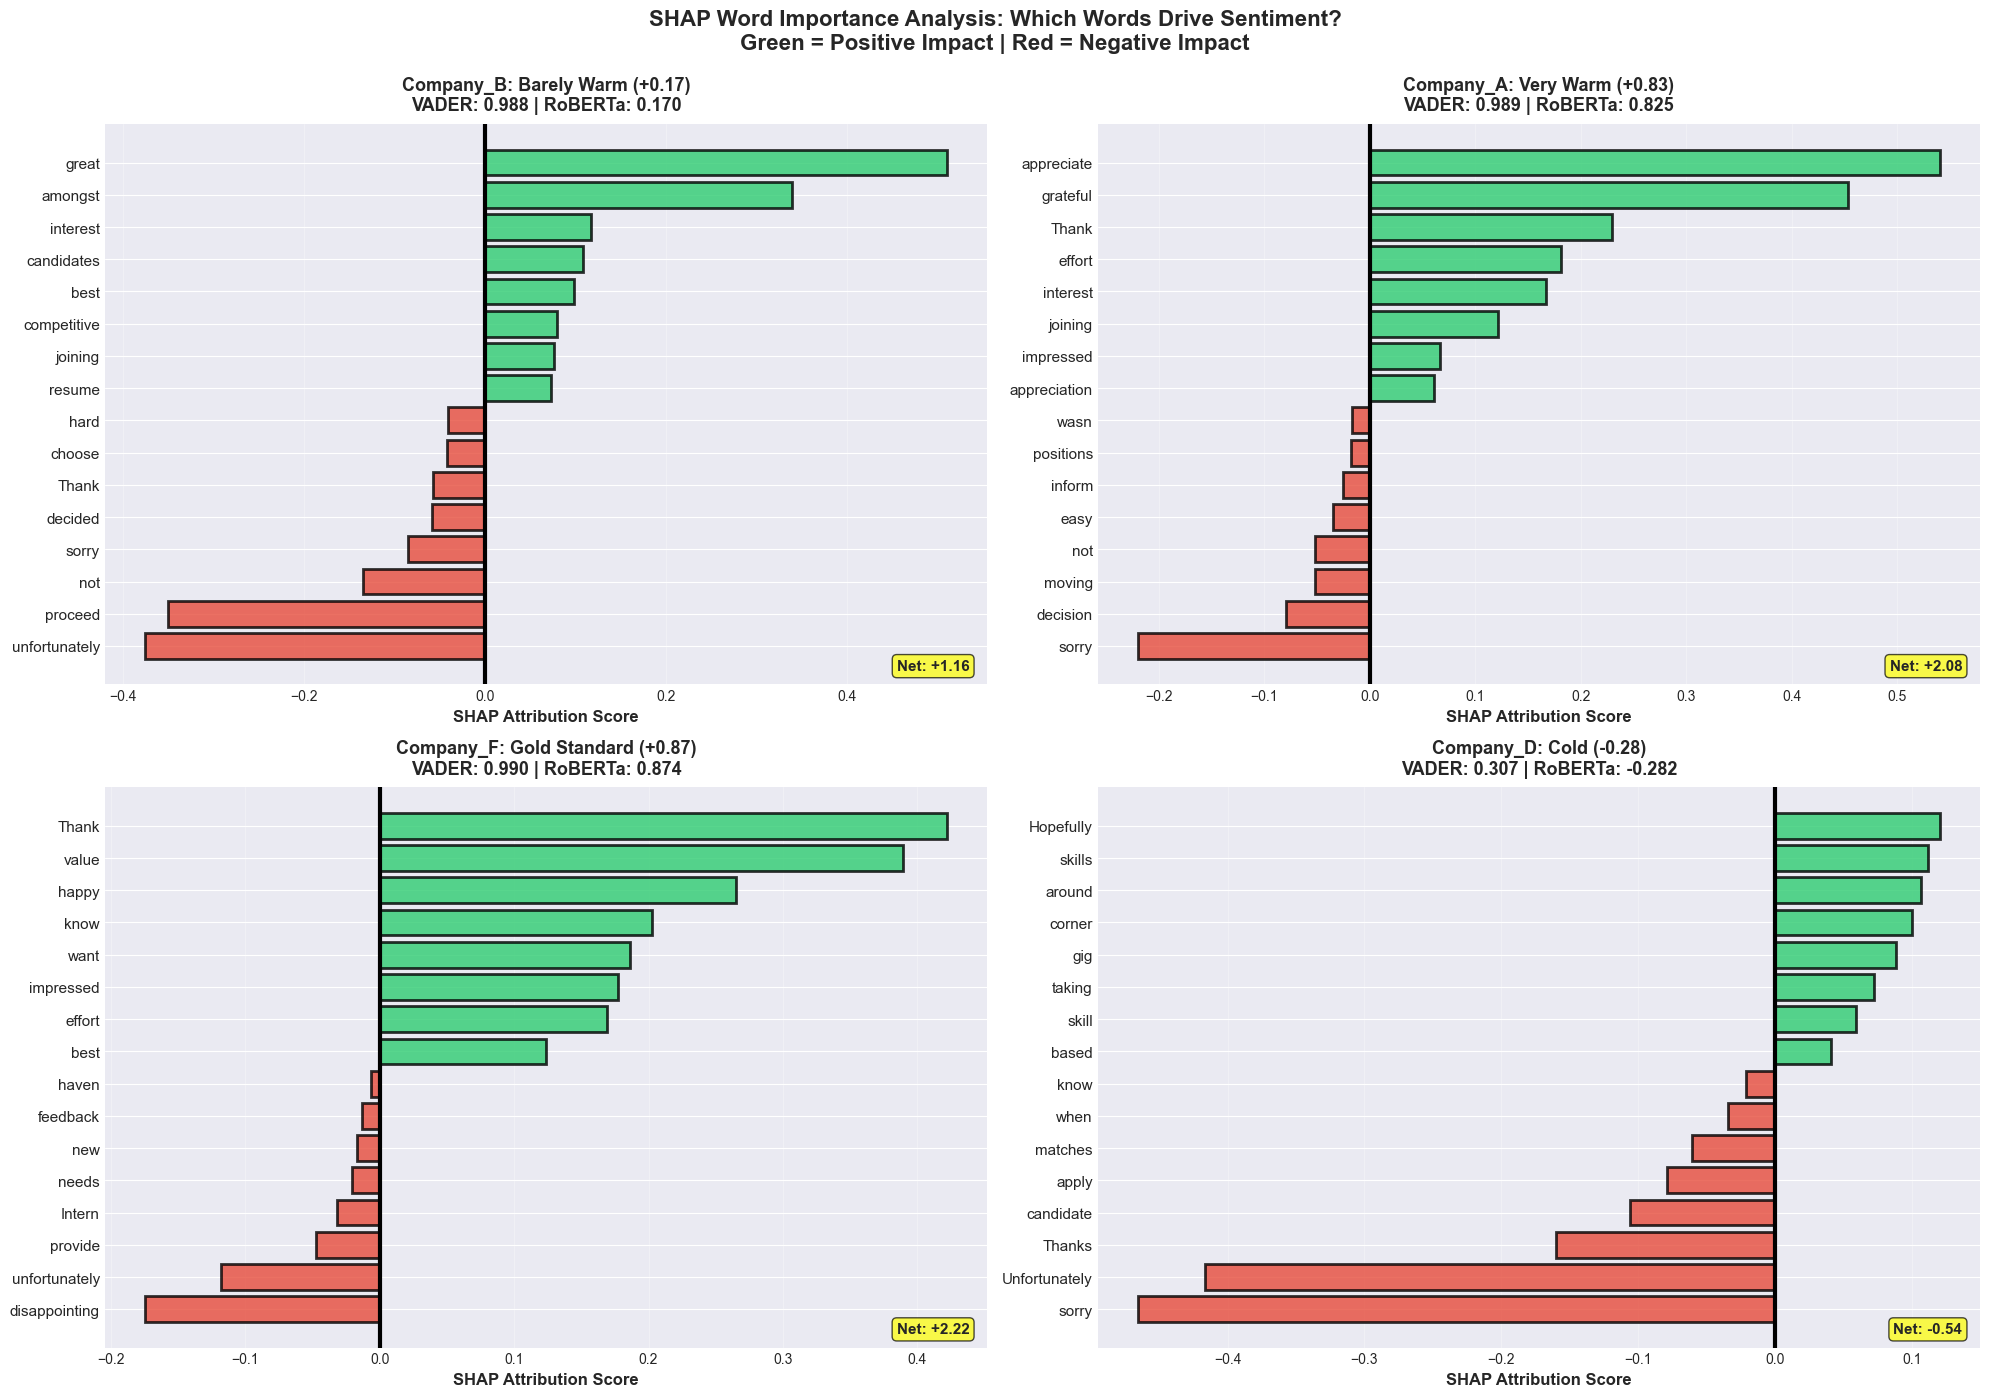

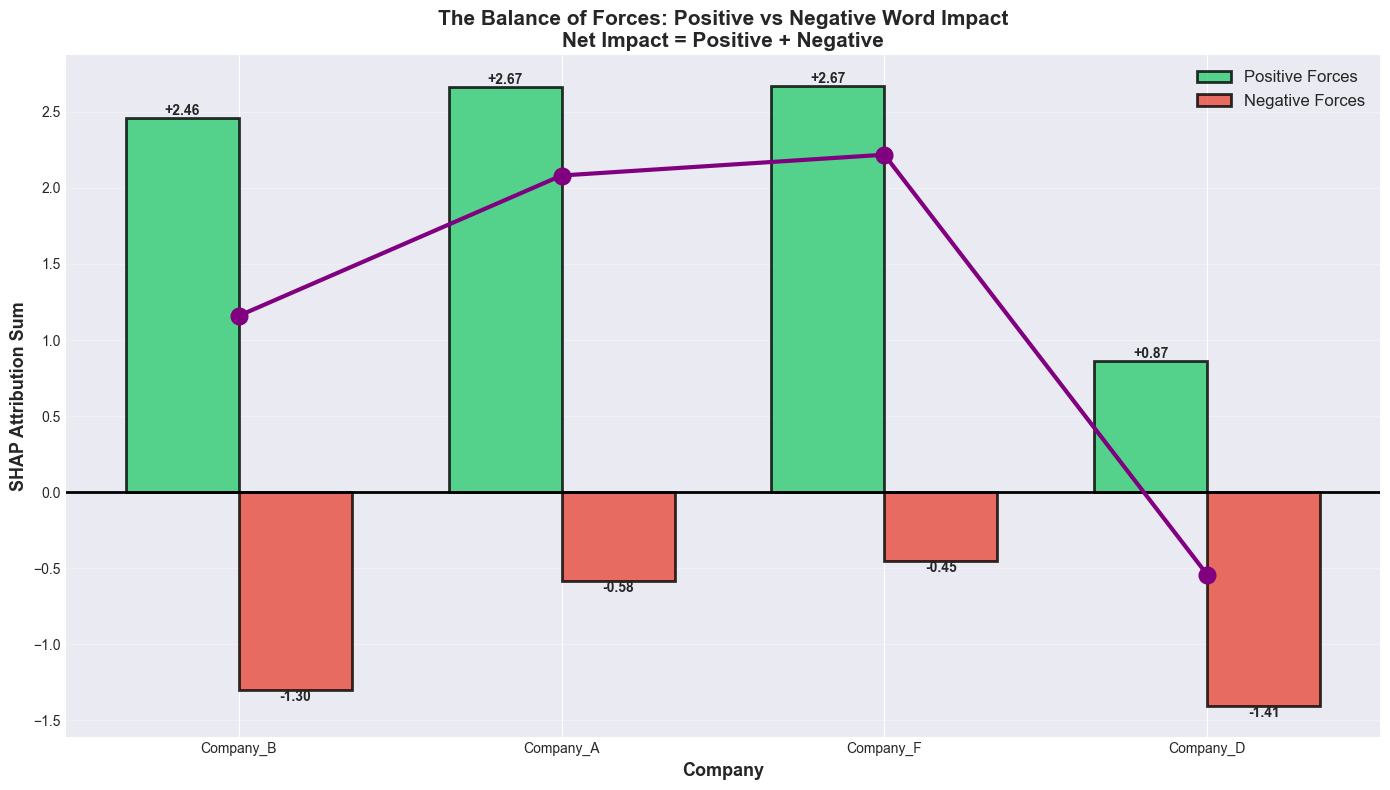

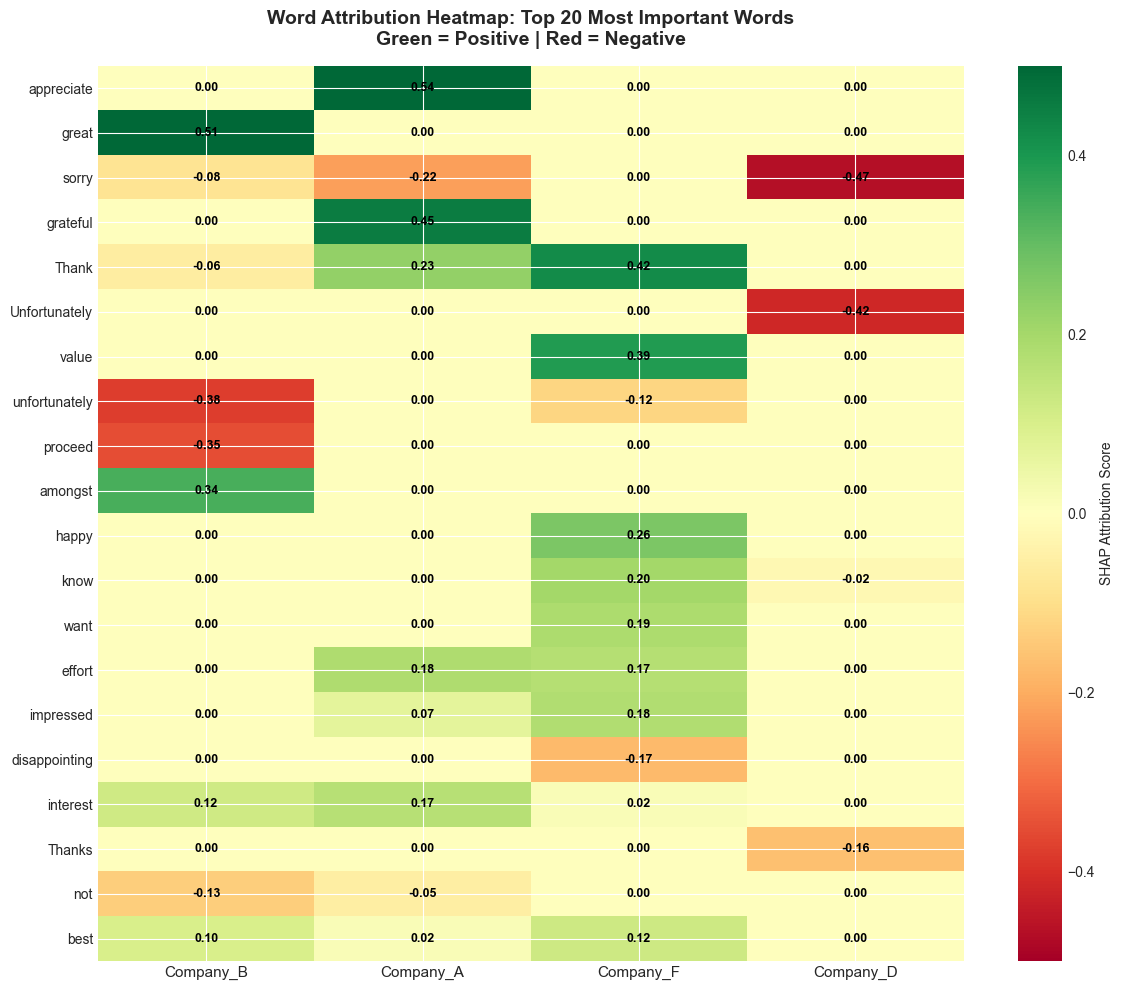

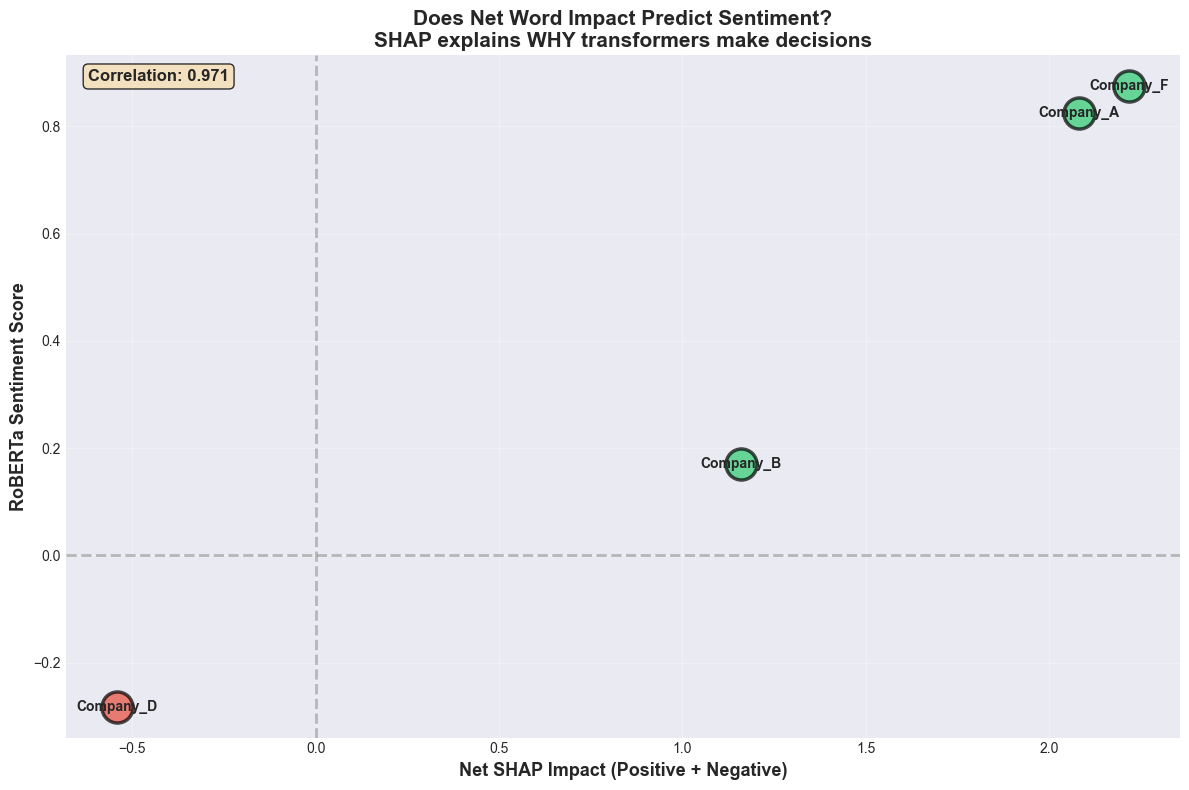

In [5]:
import json

with open('../data/shap_results.json', 'r') as f:
    shap_results = json.load(f)

word_df = pd.read_csv('../data/shap_word_attributions.csv')
summary_df = pd.read_csv('../data/shap_summary.csv')

print("✅ Data loaded!")

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

fig, axes = plt.subplots(2, 2, figsize=(20, 14))
axes = axes.flatten()

companies = ['Company_B', 'Company_A', 'Company_F', 'Company_D']
descriptions = [
    'Barely Warm (+0.17)',
    'Very Warm (+0.83)',
    'Gold Standard (+0.87)',
    'Cold (-0.28)'
]

for idx, (company, desc) in enumerate(zip(companies, descriptions)):
    ax = axes[idx]
    
    company_words = word_df[word_df['company'] == company].copy()
    
    top_positive = company_words[company_words['direction'] == 'positive'].nlargest(8, 'attribution')
    top_negative = company_words[company_words['direction'] == 'negative'].nsmallest(8, 'attribution')
    
    combined = pd.concat([top_positive, top_negative]).sort_values('attribution')
    

    colors = ['#2ecc71' if x > 0 else '#e74c3c' for x in combined['attribution']]
    bars = ax.barh(range(len(combined)), combined['attribution'], 
                   color=colors, alpha=0.8, edgecolor='black', linewidth=2)
    

    ax.set_yticks(range(len(combined)))
    ax.set_yticklabels(combined['word'], fontsize=11)
    ax.axvline(x=0, color='black', linewidth=3)
    ax.set_xlabel('SHAP Attribution Score', fontsize=12, fontweight='bold')
    

    vader = summary_df[summary_df['company'] == company]['vader'].iloc[0]
    roberta = summary_df[summary_df['company'] == company]['roberta'].iloc[0]
    
    ax.set_title(f'{company}: {desc}\n' + 
                 f'VADER: {vader:.3f} | RoBERTa: {roberta:.3f}',
                 fontsize=13, fontweight='bold', pad=10)
    
    ax.grid(axis='x', alpha=0.3)
    
    # Add net impact annotation
    net = summary_df[summary_df['company'] == company]['net_impact'].iloc[0]
    ax.text(0.98, 0.02, f'Net: {net:+.2f}',
           transform=ax.transAxes,
           fontsize=11, fontweight='bold',
           bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7),
           ha='right', va='bottom')

plt.suptitle('SHAP Word Importance Analysis: Which Words Drive Sentiment?\n' +
             'Green = Positive Impact | Red = Negative Impact',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('../visualizations/shap_word_importance_4panel.png', dpi=300, bbox_inches='tight')

fig, ax = plt.subplots(figsize=(14, 8))

x = np.arange(len(summary_df))
width = 0.35

bars1 = ax.bar(x - width/2, summary_df['positive_sum'], width,
               label='Positive Forces', color='#2ecc71', alpha=0.8,
               edgecolor='black', linewidth=2)

bars2 = ax.bar(x + width/2, summary_df['negative_sum'], width,
               label='Negative Forces', color='#e74c3c', alpha=0.8,
               edgecolor='black', linewidth=2)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:+.2f}',
                ha='center', va='bottom' if height > 0 else 'top',
                fontsize=10, fontweight='bold')

ax.set_xlabel('Company', fontsize=13, fontweight='bold')
ax.set_ylabel('SHAP Attribution Sum', fontsize=13, fontweight='bold')
ax.set_title('The Balance of Forces: Positive vs Negative Word Impact\n' +
             'Net Impact = Positive + Negative',
             fontsize=15, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(summary_df['company'])
ax.legend(fontsize=12)
ax.axhline(y=0, color='black', linewidth=2)
ax.grid(axis='y', alpha=0.3)

net_impacts = summary_df['net_impact'].values
ax.plot(x, net_impacts, 'o-', color='purple', linewidth=3, 
        markersize=12, label='Net Impact', zorder=5)

plt.tight_layout()
plt.savefig('../visualizations/shap_balance_chart.png', dpi=300, bbox_inches='tight')


fig, ax = plt.subplots(figsize=(12, 10))

# Get top 20 most important words across all companies
top_words = word_df.groupby('word')['attribution'].apply(lambda x: abs(x).max()).nlargest(20).index

# Create matrix
matrix_data = []
for word in top_words:
    row = []
    for company in companies:
        company_word = word_df[(word_df['company'] == company) & (word_df['word'] == word)]
        if len(company_word) > 0:
            row.append(company_word['attribution'].iloc[0])
        else:
            row.append(0)
    matrix_data.append(row)

matrix = np.array(matrix_data)

# Plot heatmap
im = ax.imshow(matrix, cmap='RdYlGn', aspect='auto', vmin=-0.5, vmax=0.5)

# Labels
ax.set_xticks(np.arange(len(companies)))
ax.set_yticks(np.arange(len(top_words)))
ax.set_xticklabels(companies, fontsize=11)
ax.set_yticklabels(top_words, fontsize=10)

# Add values
for i in range(len(top_words)):
    for j in range(len(companies)):
        text = ax.text(j, i, f'{matrix[i, j]:.2f}',
                      ha="center", va="center", color="black",
                      fontsize=9, fontweight='bold')

ax.set_title('Word Attribution Heatmap: Top 20 Most Important Words\n' +
             'Green = Positive | Red = Negative',
             fontsize=14, fontweight='bold', pad=15)
plt.colorbar(im, ax=ax, label='SHAP Attribution Score')

plt.tight_layout()
plt.savefig('../visualizations/shap_heatmap.png', dpi=300, bbox_inches='tight')


fig, ax = plt.subplots(figsize=(12, 8))

# Scatter plot
for _, row in summary_df.iterrows():
    color = '#2ecc71' if row['vader'] >= 0.85 else '#e74c3c'
    
    ax.scatter(row['net_impact'], row['roberta'], 
              s=500, c=color, alpha=0.7, 
              edgecolors='black', linewidth=2.5)
    
    ax.text(row['net_impact'], row['roberta'], row['company'],
           ha='center', va='center', fontsize=10, fontweight='bold')

# Add reference lines
ax.axhline(y=0, color='gray', linestyle='--', linewidth=2, alpha=0.5)
ax.axvline(x=0, color='gray', linestyle='--', linewidth=2, alpha=0.5)

# Labels
ax.set_xlabel('Net SHAP Impact (Positive + Negative)', fontsize=13, fontweight='bold')
ax.set_ylabel('RoBERTa Sentiment Score', fontsize=13, fontweight='bold')
ax.set_title('Does Net Word Impact Predict Sentiment?\n' +
             'SHAP explains WHY transformers make decisions',
             fontsize=15, fontweight='bold')
ax.grid(alpha=0.3)

# Add correlation
from scipy.stats import pearsonr
corr, p_value = pearsonr(summary_df['net_impact'], summary_df['roberta'])
ax.text(0.02, 0.98, f'Correlation: {corr:.3f}',
       transform=ax.transAxes,
       fontsize=12, fontweight='bold',
       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
       va='top')

plt.tight_layout()
plt.savefig('../visualizations/shap_net_impact_correlation.png', dpi=300, bbox_inches='tight')
